In [104]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import GPE_ensemble as GPE

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
x_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_2/xlabels.txt',delim_whitespace=True,header=None)


X_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_2/X.txt',index_col=None,delim_whitespace=True,header=None)
X_all.columns=x_labels.values.squeeze().tolist()
print(X_all)

     CV_ventricles  CV_atria     Rsys    Rpulm  a_ventricles  a_atria  \
0         0.760802  0.868096  1.70731  3.62143       3.67702  1.99947   
1         0.644653  0.697527  2.36749  1.86641       1.20492  3.66752   
2         0.652384  0.610575  3.06834  1.55817       1.80784  3.96080   
3         0.615380  0.547748  1.77233  2.63764       2.21983  3.01118   
4         0.454402  0.847549  3.38886  2.27936       2.46983  1.93714   
..             ...       ...      ...      ...           ...      ...   
995       0.548374  1.004190  2.78844  3.18274       2.70849  2.48081   
996       0.567330  0.586630  1.28949  3.35264       3.72868  1.01273   
997       0.541231  0.896994  3.76457  3.87022       1.16020  1.58567   
998       0.457154  0.380562  2.13602  3.28800       3.05301  1.98920   
999       0.592512  0.909685  1.93676  2.39699       4.79355  4.20033   

      EDP_lv   EDP_rv  
0    6.46069  6.92427  
1    1.87275  4.27266  
2    7.47750  7.07723  
3    3.85431  2.32392  
4  

In [106]:
mask = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_2/output_mask.txt',index_col=None,delim_whitespace=True,header=None)

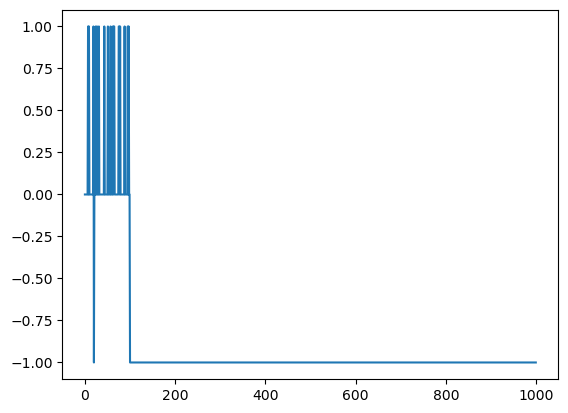

In [107]:
plt.plot(mask)

In [108]:
y_labels=pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_2/ylabels.txt',delim_whitespace=True,header=None)


y_all = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_2/Y.txt',index_col=None,delim_whitespace=True,header=None)
y_all.columns=y_labels.values.squeeze().tolist()
print(y_all)

     LVedv  LVedp   LVesv  LVpMax  LVdpdtMax  LVdpdtMin   RVedv  RVedp  \
0   150.33   4.14   95.45   70.78       1392       -731  183.33   3.51   
1   167.13   4.78  111.44   95.50       1874       -829  158.02   2.16   
2   167.34   7.46  125.29  107.22       1751       -858  150.02   2.23   
3   163.95   4.79  125.75  107.36       1807       -841  143.84   2.00   
4   167.15   7.01  117.30  111.50       1974       -929  162.27   2.30   
5   163.08   5.84  113.81   88.61       1679       -802  153.54   2.69   
6   157.80   6.54  106.20   96.67       1864       -874  167.71   2.21   
7   160.53   9.37  113.10  132.85       2241      -1048  169.76   2.23   
8   165.06   7.91  124.02  115.38       1878       -899  140.78   2.43   
9   154.33   7.72  103.36   95.81       1807       -869  171.00   2.38   
10  148.60   4.36   99.94   97.62       1946       -881  177.07   2.00   
11  141.06   5.66   89.03   91.54       1954       -874  176.49   2.49   
12  148.56   4.97  109.84  105.11     

In [109]:
y_EP = pd.read_csv(r'/Users/pmzcwl/Library/CloudStorage/OneDrive-TheUniversityofNottingham/shared_simulations/mechanics/scenario_2/Y_EP_only.txt',index_col=None,delim_whitespace=True,header=None)
y_EP.columns=y_labels[26:28]
print(y_EP)

    (A_TAT,)  (V_TAT,)
0     89.422   88.2473
1    111.616  104.4850
2    128.599  102.8290
3    141.192  109.4590
4     91.078  148.2820
..       ...       ...
94   100.926   89.9962
95    76.924  163.8680
96    97.646  120.7110
97    79.782  146.0600
98   236.933   89.8171

[99 rows x 2 columns]


In [110]:
mask

,0
0,0
1,0
2,0
3,0
4,0
...,...
995,-1
996,-1
997,-1
998,-1


In [111]:
X_run=X_all.iloc[0:99,:]

In [149]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]
input_complete=input_masked.copy().iloc[np.array(mask==1),]
input_failed=input_masked.copy().iloc[np.array(mask==0),]

In [150]:
input_complete

,CV_ventricles,CV_atria,Rsys,Rpulm,a_ventricles,a_atria,EDP_lv,EDP_rv
7,0.425206,0.868762,1.21007,3.73399,4.59964,1.53091,2.59191,1.75240
9,0.603830,0.374913,1.98891,2.29294,2.25679,1.99523,1.57295,3.10724
19,0.459663,0.576727,3.31095,1.93424,4.85942,1.78606,1.85355,5.61068
24,0.590966,0.304348,3.80092,3.76517,2.79257,4.13025,2.07563,5.16209
27,0.705182,0.450477,2.87816,1.52528,3.19342,3.96461,2.42071,2.82968
31,0.491409,0.985488,2.06718,2.27277,4.61212,4.61397,1.51899,5.49587
43,0.514725,0.435274,2.22155,1.78580,4.05656,2.23212,3.52061,2.54710
51,0.694628,0.482147,3.89395,1.04788,3.03173,2.53249,6.06477,2.16743
57,0.593308,0.858043,3.77534,1.87643,3.96103,4.83981,4.22418,7.39297
62,0.411168,0.806552,2.22592,1.61506,4.61831,3.32068,5.34888,2.55497


In [151]:
n_samp = 16

In [152]:
fail_input_train = input_failed.sample(n_samp)
fail_output_train = mask.loc[fail_input_train.index]

In [153]:
fail_input_test=input_failed.loc[~input_failed.index.isin(fail_input_train.index)]
fail_output_test=mask.loc[fail_input_test.index]

In [154]:
complete_input_train = input_complete.sample(n_samp)
complete_output_train = mask.loc[complete_input_train.index]

In [155]:
complete_input_test=input_complete.loc[~input_complete.index.isin(complete_input_train.index)]
complete_output_test=mask.loc[complete_input_test.index]

In [156]:
y_train = pd.concat([fail_output_train,complete_output_train])
y_test = pd.concat([fail_output_test,complete_output_test])

x_train = pd.concat([fail_input_train,complete_input_train])
x_test= pd.concat([fail_input_test,complete_input_test])


In [157]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [158]:
model = LogisticRegression(solver='liblinear', random_state=0)


In [159]:
model.fit(x_train.values, y_train.values.squeeze())


LogisticRegression(random_state=0, solver='liblinear')

In [160]:
complete_input_test.values

array([[0.459663, 0.576727, 3.31095 , 1.93424 , 4.85942 , 1.78606 ,
        1.85355 , 5.61068 ],
       [0.705182, 0.450477, 2.87816 , 1.52528 , 3.19342 , 3.96461 ,
        2.42071 , 2.82968 ]])

In [161]:
model.score(complete_input_test.values,complete_output_test.values.squeeze())

0.5

In [162]:
model.score(fail_input_test.values,fail_output_test.values.squeeze())

0.5692307692307692

In [170]:
input_masked = y_EP.copy().iloc[0:mask.shape[0]]
input_complete=input_masked.copy().iloc[np.array(mask[0:99]==1),]
input_failed=input_masked.copy().iloc[np.array(mask[0:99]==0),]

In [25]:
fail_input_train = input_failed.sample(n_samp)
fail_output_train = mask.loc[fail_input_train.index]

In [26]:
fail_input_test=input_failed.loc[~input_failed.index.isin(fail_input_train.index)]
fail_output_test=mask.loc[fail_input_test.index]

In [27]:
complete_input_train = input_complete.sample(n_samp)
complete_output_train = mask.loc[complete_input_train.index]

In [28]:
complete_input_test=input_complete.loc[~input_complete.index.isin(complete_input_train.index)]
complete_output_test=mask.loc[complete_input_test.index]

In [29]:
y_train = pd.concat([fail_output_train,complete_output_train])
y_test = pd.concat([fail_output_test,complete_output_test])

x_train = pd.concat([fail_input_train,complete_input_train])
x_test= pd.concat([fail_input_test,complete_input_test])


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
model = LogisticRegression(solver='liblinear', random_state=0)


In [32]:
model.fit(x_train.values, y_train.values.squeeze())


LogisticRegression(random_state=0, solver='liblinear')

In [33]:
model.score(complete_input_test.values,complete_output_test.values.squeeze())

0.5

In [34]:
model.score(fail_input_test.values,fail_output_test.values.squeeze())

0.46875

In [165]:
input_failed.iloc[[1]]

,CV_ventricles,CV_atria,Rsys,Rpulm,a_ventricles,a_atria,EDP_lv,EDP_rv
1,0.644653,0.697527,2.36749,1.86641,1.20492,3.66752,1.87275,4.27266


In [169]:
input_masked

,CV_ventricles,CV_atria,Rsys,Rpulm,a_ventricles,a_atria,EDP_lv,EDP_rv
0,0.760802,0.868096,1.70731,3.62143,3.67702,1.99947,6.46069,6.92427
1,0.644653,0.697527,2.36749,1.86641,1.20492,3.66752,1.87275,4.27266
2,0.652384,0.610575,3.06834,1.55817,1.80784,3.96080,7.47750,7.07723
3,0.615380,0.547748,1.77233,2.63764,2.21983,3.01118,3.85431,2.32392
4,0.454402,0.847549,3.38886,2.27936,2.46983,1.93714,2.19568,3.23450
...,...,...,...,...,...,...,...,...
995,0.548374,1.004190,2.78844,3.18274,2.70849,2.48081,4.01463,4.05085
996,0.567330,0.586630,1.28949,3.35264,3.72868,1.01273,5.98973,2.85412
997,0.541231,0.896994,3.76457,3.87022,1.16020,1.58567,3.91728,1.55156
998,0.457154,0.380562,2.13602,3.28800,3.05301,1.98920,7.37215,6.18801


In [197]:
input_complete.shape[0]

18

In [257]:
reps=10
fail_score = 0
success_score = 0

for j in range(reps):
    fail_input_train = input_failed.sample(17)
    fail_output_train = mask.loc[fail_input_train.index]
    fail_input_test=input_failed.loc[~input_failed.index.isin(fail_input_train.index)]
    fail_output_test=mask.loc[fail_input_test.index]
    for i in range(input_complete.shape[0]):


        complete_input_test=input_complete.iloc[[i]]
        complete_output_test=mask.loc[complete_input_test.index]
        complete_input_train = input_complete.loc[~input_complete.index.isin(complete_input_test.index)]
        complete_output_train = mask.loc[complete_input_train.index]


        y_train = pd.concat([fail_output_train,complete_output_train])
        y_test = pd.concat([fail_output_test,complete_output_test])

        x_train = pd.concat([fail_input_train,complete_input_train])
        x_test= pd.concat([fail_input_test,complete_input_test])

        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(x_train.values, y_train.values.squeeze())

        success_score+=model.predict(complete_input_test.values)/input_complete.shape[0]/reps
        fail_score+=model.score(fail_input_test.values,fail_output_test.values.squeeze())/reps/input_complete.shape[0]

In [258]:
success_score

array([0.54444444])

In [259]:
fail_score

0.5001763668430336

In [226]:
model.predict(fail_input_test.values)

array([0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1])

In [227]:
input_complete

,"(A_TAT,)","(V_TAT,)"
7,88.741,157.8310
9,206.155,111.5190
19,133.964,146.5430
24,146.898,163.7600
27,171.566,104.0110
31,124.818,139.9830
43,77.313,172.7660
51,246.824,88.7456
57,105.572,154.3100
62,197.540,95.0961


# Emulator

In [265]:
input_masked = X_all.copy().iloc[0:mask.shape[0]]

In [266]:
input_masked=input_masked.iloc[np.array(mask==1),]
input_masked.index = y_all.index

In [267]:
input_masked.shape

(18, 8)

In [268]:
y_all.shape

(18, 28)

In [269]:
y_all.index[0]

0

In [270]:
nsamp=100
MSE = np.zeros((y_all.shape[0],y_all.shape[1]))

for i in range(y_all.shape[0]):
    y_train = y_all.copy().drop(y_all.index[i])
    X_train = input_masked.copy().drop(y_all.index[i])
    
    y_test = y_all.loc[[y_all.index[i]]]
    X_test = input_masked.loc[[y_all.index[i]]]
    
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    MSE[i,:] = emulator.MSE(X_test,y_test).detach().numpy()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [42]:
1-MSE.mean(axis=0)/np.var(y_all,axis=0)

LVedv        0.927715
LVedp        0.961065
LVesv        0.955695
LVpMax       0.972139
LVdpdtMax    0.765353
LVdpdtMin    0.935163
RVedv        0.941501
RVedp        0.434360
RVesv        0.929844
RVpMax       0.958775
RVdpdtMax    0.931797
RVdpdtMin    0.991750
LAedv        0.839485
LAesv        0.873917
LAvMax       0.879095
LApMax       0.973557
RAedv        0.650181
RAesv        0.856159
RAvMax       0.779222
RApMax       0.860048
LAsvA        0.923040
LAinflV      0.892643
LAsvV        0.793124
RAsvA        0.811002
RAinflV      0.924814
RAsvV        0.875061
A_TAT        0.786568
V_TAT        0.930945
dtype: float64

In [283]:
MSE.shape

(18, 28)

In [298]:
MSE[0].shape

(28,)

In [300]:
np.var(y_all,axis=0).shape

(28,)

In [309]:
R2=np.zeros((18,28))
for i in range(18):
    R2[i]=(1-MSE[i]/np.var(y_all,axis=0))

In [313]:
R2.std(axis=0)

array([0.0672855 , 0.07331823, 0.05122411, 0.0373395 , 0.21443833,
       0.07250802, 0.06575165, 0.53520579, 0.05808018, 0.06185106,
       0.080434  , 0.00773155, 0.27470743, 0.09830301, 0.16124557,
       0.0307408 , 0.55025551, 0.27351011, 0.38936127, 0.15040021,
       0.11895316, 0.11740392, 0.20730075, 0.21215804, 0.08705475,
       0.12237502, 0.31872529, 0.07008053])

In [318]:
R2[:,16]

array([ 0.81192693,  0.91992857, -1.40587185,  0.91445134,  0.95775076,
        0.96305821,  0.77514589,  0.6117299 ,  0.37953291,  0.77575059,
        0.68774339,  0.79833162,  0.99756628,  0.97112785,  0.45937649,
        0.94926017,  0.11973882,  0.96830375])

In [311]:
np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0))

array([0.92587838, 0.95716358, 0.95858899, 0.97208867, 0.80063911,
       0.93496725, 0.94344247, 0.50380639, 0.94147158, 0.95108635,
       0.93262794, 0.99331973, 0.80902482, 0.88135272, 0.87241852,
       0.97142946, 0.64749176, 0.86095687, 0.77952535, 0.87401098,
       0.92515724, 0.88698379, 0.82345375, 0.80813217, 0.92949367,
       0.90020525, 0.71095385, 0.93452004])

In [280]:
np.array((1-MSE)/np.var(y_all,axis=0))

ValueError: Length of values (18) does not match length of index (28)

In [323]:
np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)).shape

(28,)

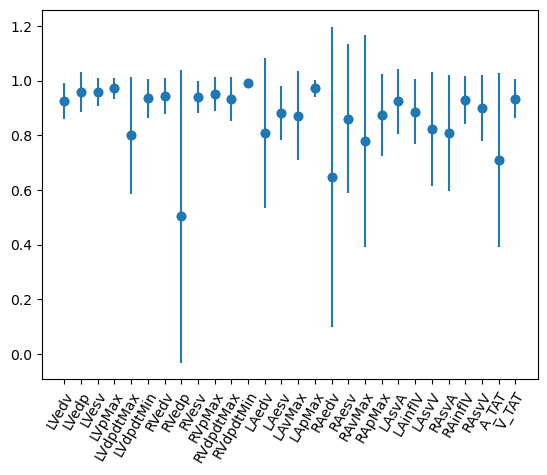

In [324]:
fig, ax = plt.subplots()


ax.scatter(y_labels.values.squeeze(),np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)))
plt.errorbar(y_labels.values.squeeze(),np.array(1-MSE.mean(axis=0)/np.var(y_all,axis=0)),fmt='o',yerr=R2.std(axis=0))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [44]:
emulator.predict(pd.DataFrame([-0.1*np.ones(8)],columns=X_all.columns))

tensor([[ 180.3322,    5.7459,  104.6176,   81.9353, 1758.3118, -753.1107,
          162.0728,    1.9114,   93.7689,   19.7708,  324.4873, -187.4140,
           91.0600,   75.7505,  109.6514,    5.3364,   75.5839,   67.4763,
           96.5049,    2.0504,   15.3419,   18.5972,   21.9294,    7.2203,
           21.7481,   22.5847,  343.7579,  272.2045]],
       grad_fn=<PermuteBackward0>)

In [45]:
pd.DataFrame([np.ones(8)],columns=X_all.columns)

,CV_ventricles,CV_atria,Rsys,Rpulm,a_ventricles,a_atria,EDP_lv,EDP_rv
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [46]:
y_all

,LVedv,LVedp,LVesv,LVpMax,LVdpdtMax,LVdpdtMin,RVedv,RVedp,RVesv,RVpMax,...,RAvMax,RApMax,LAsvA,LAinflV,LAsvV,RAsvA,RAinflV,RAsvV,A_TAT,V_TAT
0,150.33,4.14,95.45,70.78,1392,-731,183.33,3.51,131.71,36.04,...,94.86,4.06,15.84,9.95,14.90,14.79,18.60,18.88,88.741,157.8310
1,167.13,4.78,111.44,95.50,1874,-829,158.02,2.16,103.96,30.53,...,86.09,2.31,13.98,12.34,16.58,7.35,16.99,17.64,206.155,111.5190
2,167.34,7.46,125.29,107.22,1751,-858,150.02,2.23,106.73,26.38,...,74.86,2.16,17.93,9.61,13.54,7.74,13.59,14.21,133.964,146.5430
3,163.95,4.79,125.75,107.36,1807,-841,143.84,2.00,103.54,34.99,...,77.94,1.35,8.26,7.65,10.28,3.93,10.77,11.66,254.035,113.7630
4,167.15,7.01,117.30,111.50,1974,-929,162.27,2.30,109.29,28.15,...,83.57,1.81,12.27,11.09,12.92,5.43,13.67,14.34,170.619,95.6590
5,163.08,5.84,113.81,88.61,1679,-802,153.54,2.69,107.62,27.92,...,79.96,3.13,13.25,8.39,11.72,7.42,12.04,12.36,78.283,137.0320
6,157.80,6.54,106.20,96.67,1864,-874,167.71,2.21,116.84,27.54,...,87.22,2.26,14.18,10.82,13.88,7.44,16.19,16.85,176.830,130.8490
7,160.53,9.37,113.10,132.85,2241,-1048,169.76,2.23,114.18,28.05,...,85.88,1.45,15.98,11.52,12.13,6.92,15.39,17.06,161.159,96.6604
8,165.06,7.91,124.02,115.38,1878,-899,140.78,2.43,97.76,27.68,...,75.33,2.39,13.39,7.91,10.04,6.33,10.47,10.94,90.403,113.4240
9,154.33,7.72,103.36,95.81,1807,-869,171.00,2.38,120.10,26.57,...,86.21,2.75,15.18,9.72,11.56,8.28,14.23,14.66,95.776,163.2930


In [47]:
y_all

,LVedv,LVedp,LVesv,LVpMax,LVdpdtMax,LVdpdtMin,RVedv,RVedp,RVesv,RVpMax,...,RAvMax,RApMax,LAsvA,LAinflV,LAsvV,RAsvA,RAinflV,RAsvV,A_TAT,V_TAT
0,150.33,4.14,95.45,70.78,1392,-731,183.33,3.51,131.71,36.04,...,94.86,4.06,15.84,9.95,14.90,14.79,18.60,18.88,88.741,157.8310
1,167.13,4.78,111.44,95.50,1874,-829,158.02,2.16,103.96,30.53,...,86.09,2.31,13.98,12.34,16.58,7.35,16.99,17.64,206.155,111.5190
2,167.34,7.46,125.29,107.22,1751,-858,150.02,2.23,106.73,26.38,...,74.86,2.16,17.93,9.61,13.54,7.74,13.59,14.21,133.964,146.5430
3,163.95,4.79,125.75,107.36,1807,-841,143.84,2.00,103.54,34.99,...,77.94,1.35,8.26,7.65,10.28,3.93,10.77,11.66,254.035,113.7630
4,167.15,7.01,117.30,111.50,1974,-929,162.27,2.30,109.29,28.15,...,83.57,1.81,12.27,11.09,12.92,5.43,13.67,14.34,170.619,95.6590
5,163.08,5.84,113.81,88.61,1679,-802,153.54,2.69,107.62,27.92,...,79.96,3.13,13.25,8.39,11.72,7.42,12.04,12.36,78.283,137.0320
6,157.80,6.54,106.20,96.67,1864,-874,167.71,2.21,116.84,27.54,...,87.22,2.26,14.18,10.82,13.88,7.44,16.19,16.85,176.830,130.8490
7,160.53,9.37,113.10,132.85,2241,-1048,169.76,2.23,114.18,28.05,...,85.88,1.45,15.98,11.52,12.13,6.92,15.39,17.06,161.159,96.6604
8,165.06,7.91,124.02,115.38,1878,-899,140.78,2.43,97.76,27.68,...,75.33,2.39,13.39,7.91,10.04,6.33,10.47,10.94,90.403,113.4240
9,154.33,7.72,103.36,95.81,1807,-869,171.00,2.38,120.10,26.57,...,86.21,2.75,15.18,9.72,11.56,8.28,14.23,14.66,95.776,163.2930


In [48]:
y_labels.loc[0].values

array(['LVedv'], dtype=object)

In [49]:
y_all.iloc[:,1:2]

,LVedp
0,4.14
1,4.78
2,7.46
3,4.79
4,7.01
5,5.84
6,6.54
7,9.37
8,7.91
9,7.72


In [50]:
y_all.columns

Index(['LVedv', 'LVedp', 'LVesv', 'LVpMax', 'LVdpdtMax', 'LVdpdtMin', 'RVedv',
       'RVedp', 'RVesv', 'RVpMax', 'RVdpdtMax', 'RVdpdtMin', 'LAedv', 'LAesv',
       'LAvMax', 'LApMax', 'RAedv', 'RAesv', 'RAvMax', 'RApMax', 'LAsvA',
       'LAinflV', 'LAsvV', 'RAsvA', 'RAinflV', 'RAsvV', 'A_TAT', 'V_TAT'],
      dtype='object')

In [325]:
y_calibration = y_all.loc[:,['V_TAT','LVpMax','LVedv']]

In [326]:
y_calibration2 = pd.DataFrame({'LV_EF':(y_all.loc[:,'LVedv']-y_all.loc[:,'LVesv'])/y_all.loc[:,'LVedv']})

In [327]:
y_calibration=y_calibration.join(y_calibration2)

In [345]:
MSE = np.zeros((y_calibration.shape[0],y_calibration.shape[1]))

for i in range(y_calibration.shape[0]):
    y_train = y_calibration.copy().drop(y_calibration.index[i])
    X_train = input_masked.copy().drop(y_calibration.index[i])
    
    y_test = y_calibration.loc[[y_calibration.index[i]]]
    X_test = input_masked.loc[[y_calibration.index[i]]]
    print(y_test)
    emulator = GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)
    MSE[i,:] = emulator.MSE(X_test,y_test).detach().numpy()

     V_TAT  LVpMax   LVedv     LV_EF
0  157.831   70.78  150.33  0.365064
0
1
2
3
     V_TAT  LVpMax   LVedv     LV_EF
1  111.519    95.5  167.13  0.333214
0
1
2
3
     V_TAT  LVpMax   LVedv     LV_EF
2  146.543  107.22  167.34  0.251285
0
1
2
3
     V_TAT  LVpMax   LVedv     LV_EF
3  113.763  107.36  163.95  0.232998
0
1
2
3
    V_TAT  LVpMax   LVedv     LV_EF
4  95.659   111.5  167.15  0.298235
0
1
2
3
     V_TAT  LVpMax   LVedv     LV_EF
5  137.032   88.61  163.08  0.302122
0
1
2
3
     V_TAT  LVpMax  LVedv     LV_EF
6  130.849   96.67  157.8  0.326996
0
1
2
3
     V_TAT  LVpMax   LVedv     LV_EF
7  96.6604  132.85  160.53  0.295459
0
1
2
3
     V_TAT  LVpMax   LVedv     LV_EF
8  113.424  115.38  165.06  0.248637
0
1
2
3
     V_TAT  LVpMax   LVedv     LV_EF
9  163.293   95.81  154.33  0.330266
0
1
2
3
      V_TAT  LVpMax  LVedv     LV_EF
10  85.1998   97.62  148.6  0.327456
0
1
2
3
      V_TAT  LVpMax   LVedv    LV_EF
11  111.584   91.54  141.06  0.36885
0
1
2
3
    V_TAT  LVpMax   

In [346]:
R2=np.zeros((18,4))
for i in range(18):
    R2[i]=(1-MSE[i]/np.var(y_calibration,axis=0))

In [351]:
R2.std(axis=0)

array([0.07004877, 0.03734413, 0.06785411, 0.02837007])

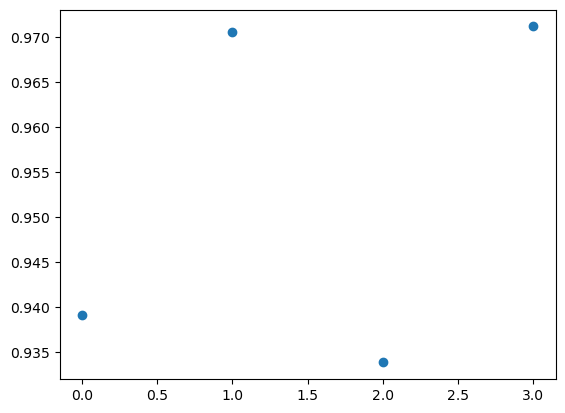

In [352]:
plt.plot(np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)),'o')

In [353]:
y_calibration.columns.values.tolist()

['V_TAT', 'LVpMax', 'LVedv', 'LV_EF']

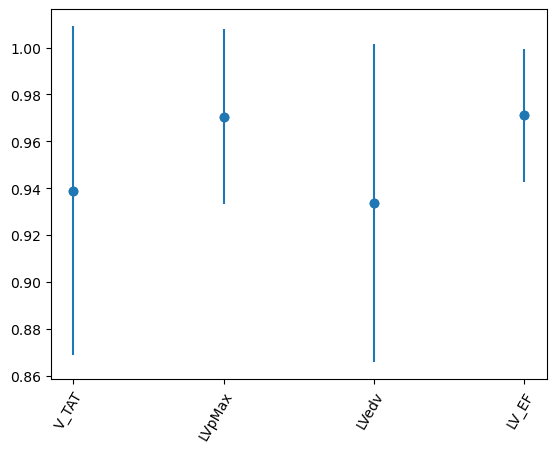

In [354]:
fig, ax = plt.subplots()


ax.scatter(y_calibration.columns.values.tolist(),np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)))
plt.errorbar(y_calibration.columns.values.tolist(),np.array(1-MSE.mean(axis=0)/np.var(y_calibration,axis=0)),fmt='o',yerr=R2.std(axis=0))
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

In [56]:
X_train = input_masked

In [57]:
y_train=y_calibration

In [58]:
X_train

,CV_ventricles,CV_atria,Rsys,Rpulm,a_ventricles,a_atria,EDP_lv,EDP_rv
0,0.425206,0.868762,1.21007,3.73399,4.59964,1.53091,2.59191,1.75240
1,0.603830,0.374913,1.98891,2.29294,2.25679,1.99523,1.57295,3.10724
2,0.459663,0.576727,3.31095,1.93424,4.85942,1.78606,1.85355,5.61068
3,0.590966,0.304348,3.80092,3.76517,2.79257,4.13025,2.07563,5.16209
4,0.705182,0.450477,2.87816,1.52528,3.19342,3.96461,2.42071,2.82968
5,0.491409,0.985488,2.06718,2.27277,4.61212,4.61397,1.51899,5.49587
6,0.514725,0.435274,2.22155,1.78580,4.05656,2.23212,3.52061,2.54710
7,0.694628,0.482147,3.89395,1.04788,3.03173,2.53249,6.06477,2.16743
8,0.593308,0.858043,3.77534,1.87643,3.96103,4.83981,4.22418,7.39297
9,0.411168,0.806552,2.22592,1.61506,4.61831,3.32068,5.34888,2.55497


In [59]:
emulator=GPE.ensemble(X_train,y_train,mean_func="linear",training_iter=500)

0
1
2
3


In [60]:
nDim = X_train.shape[1]
boundsMaxMin = []
for i in range(nDim):
    boundsMaxMin.append([np.min(X_train.iloc[:,i]),np.max(X_train.iloc[:,i])])
    print(boundsMaxMin[i])

[0.407686, 0.786536]
[0.304348, 0.985488]
[1.21007, 3.89395]
[1.04788, 3.85526]
[2.25679, 4.98784]
[1.53091, 4.83981]
[1.51899, 7.4972]
[1.18509, 7.39297]


In [61]:
##### from SALib.sample import saltelli
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Define the model inputs
problem = {
    'num_vars': nDim,
    'names': x_labels,
    'bounds': boundsMaxMin
    #'bounds': [[-1, 1],
     #          [-1, 1],
      #         [-1, 1],
       #        [-1, 1],
        #       [-1, 1],
         #      [-1, 1],
          #     [-1, 1],
           #    [-1, 1],
            #   [-1,1]]
}

# Generate samples
param_values = saltelli.sample(problem, 1024)

data1 = pd.DataFrame(param_values,columns=X_train.columns)
#data1.columns = X_train.columns

Ymean=emulator.predict(data1)

/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_49916/628021900.py:24: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1024)


In [62]:
Si = []
nMod = y_train.shape[1]
nDim = X_train.shape[1]
for i in range(nMod):
    Si.append(sobol.analyze(problem, Ymean[:,i].detach().numpy(), print_to_console=True,calc_second_order=True))

                        ST       ST_conf
(CV_ventricles,)  0.999827  5.907133e-02
(CV_atria,)       0.000193  1.557399e-05
(Rsys,)           0.000287  2.470710e-05
(Rpulm,)          0.000031  4.338511e-06
(a_ventricles,)   0.000015  1.392832e-06
(a_atria,)        0.000007  8.800941e-07
(EDP_lv,)         0.000174  1.436140e-05
(EDP_rv,)         0.000134  1.446652e-05
                        S1   S1_conf
(CV_ventricles,)  0.999823  0.071838
(CV_atria,)       0.000191  0.001125
(Rsys,)           0.000283  0.001429
(Rpulm,)         -0.000063  0.000538
(a_ventricles,)   0.000015  0.000305
(a_atria,)       -0.000128  0.000230
(EDP_lv,)         0.000169  0.001126
(EDP_rv,)         0.000119  0.001110
Empty DataFrame
Columns: [S2, S2_conf]
Index: []
                        ST   ST_conf
(CV_ventricles,)  0.005959  0.000498
(CV_atria,)       0.000442  0.000043
(Rsys,)           0.796984  0.052842
(Rpulm,)          0.148799  0.013032
(a_ventricles,)   0.021867  0.001826
(a_atria,)        0.000025 

In [63]:
Si_first=np.zeros((nDim,nMod))
Si_total=np.zeros((nDim,nMod))
for i in range(nMod):
    total_Si, first_Si, second_Si = Si[i].to_df()
    Si_first[:,i] =  first_Si.iloc[:,0]
    Si_total[:,i] =  total_Si.iloc[:,0]


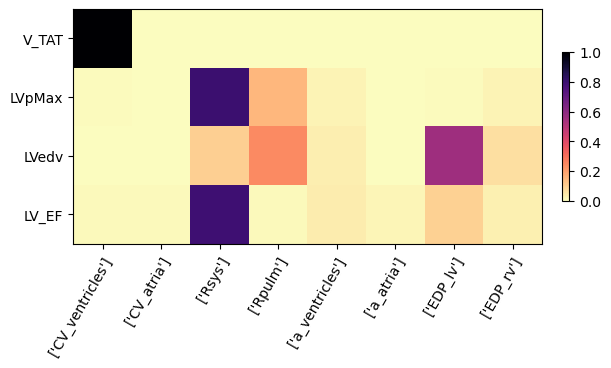

In [64]:
inputs = x_labels.values.tolist()
outputs = y_calibration.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_first.T[0:10],cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

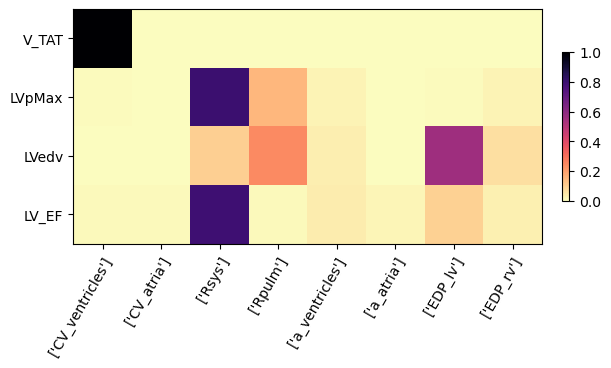

In [65]:
inputs = x_labels.values.tolist()
outputs = y_calibration.columns.tolist()
fig, ax = plt.subplots()
im = ax.imshow(Si_total.T,cmap='magma_r',vmin=0,vmax=1)

ax.set_yticks(np.arange(len(outputs)),labels=outputs)
ax.set_xticks(np.arange(len(inputs)), labels=inputs)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor");

plt.colorbar(im,fraction=0.015, pad=0.04)

In [66]:
Si[i].to_df()

[                        ST   ST_conf
 (CV_ventricles,)  0.008075  0.000731
 (CV_atria,)       0.011077  0.000904
 (Rsys,)           0.790982  0.056899
 (Rpulm,)          0.010232  0.000751
 (a_ventricles,)   0.037069  0.002889
 (a_atria,)        0.016740  0.001494
 (EDP_lv,)         0.094760  0.008298
 (EDP_rv,)         0.031046  0.002805,
                         S1   S1_conf
 (CV_ventricles,)  0.008029  0.007143
 (CV_atria,)       0.011088  0.007898
 (Rsys,)           0.790963  0.054426
 (Rpulm,)          0.010233  0.008215
 (a_ventricles,)   0.037055  0.015090
 (a_atria,)        0.016759  0.010814
 (EDP_lv,)         0.094737  0.023999
 (EDP_rv,)         0.031007  0.014545,
 Empty DataFrame
 Columns: [S2, S2_conf]
 Index: []]

In [67]:
y_calibration

,V_TAT,LVpMax,LVedv,LV_EF
0,157.8310,70.78,150.33,0.365064
1,111.5190,95.50,167.13,0.333214
2,146.5430,107.22,167.34,0.251285
3,113.7630,107.36,163.95,0.232998
4,95.6590,111.50,167.15,0.298235
5,137.0320,88.61,163.08,0.302122
6,130.8490,96.67,157.80,0.326996
7,96.6604,132.85,160.53,0.295459
8,113.4240,115.38,165.06,0.248637
9,163.2930,95.81,154.33,0.330266


In [82]:
np.array(boundsMaxMin)[:,1]

array([0.786536, 0.985488, 3.89395 , 3.85526 , 4.98784 , 4.83981 ,
       7.4972  , 7.39297 ])

In [68]:
centre = (np.array(boundsMaxMin)[:,1]+np.array(boundsMaxMin)[:,0])/2

In [69]:
centre

array([0.597111, 0.644918, 2.55201 , 2.45157 , 3.622315, 3.18536 ,
       4.508095, 4.28903 ])

In [70]:
import emcee
ndim = nDim
nwalkers = 20
p0 = np.random.multivariate_normal(centre, 0.001*np.identity(ndim), size=(nwalkers))
y_val = [100,157,111,0.8]

In [375]:
def log_prior(theta):
    
    #if (np.array(boundsMaxMin)[:,0]<theta).all() and (theta<np.array(boundsMaxMin)[:,1]).all():
        
    if (0<theta).all() and (theta<np.array(boundsMaxMin)[:,1]+20).all():
        return 0.0
    return -np.inf

In [376]:
def log_likelihood(x,emulator,y_val):
    x=pd.DataFrame(x).T
    x.columns = x_labels.values.squeeze().tolist()
    y_val = pd.DataFrame(y_val).T
    y_val.columns = y_train.columns.values.squeeze().tolist()
    ll =np.sum(emulator.ensemble_log_likelihood(x,y_val))
    return ll

In [377]:
def log_prob(theta, emulator,y_val):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta,emulator, y_val)

In [378]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[emulator,y_val])

In [379]:
x = np.zeros(8)
x=pd.DataFrame(x).T
x.columns = x_labels.values.squeeze().tolist()

In [380]:
for i in range(20):
    print(log_prob(p0[i],emulator,y_val))

-15176.611083984375
-14891.565185546875
-14863.836975097656
-14578.205535888672
-13998.365440368652
-16040.806457519531
-14378.013061523438
-14713.36328125
-13998.411386966705
-15662.811096191406
-15106.110473632812
-14397.45980834961
-15298.784912109375
-15169.152709960938
-15038.416320800781
-14330.711547851562
-14270.723876953125
-16061.119201660156
-14033.60905456543
-14206.492889404297


In [381]:
sampler.run_mcmc(p0, 100000)

State([[6.98848666e-01 2.08465837e+01 2.51363151e+00 3.95163642e+00
  3.52522965e-01 2.95754781e+00 2.74654505e+01 2.40368133e-01]
 [7.25947268e-01 2.09571455e+01 2.57822952e+00 4.32926055e+00
  5.44377430e-01 1.62987578e+00 2.74310744e+01 3.57025854e-01]
 [6.68073325e-01 2.09196645e+01 2.83150903e+00 4.76481797e+00
  9.51883596e-02 3.15867629e-01 2.74951356e+01 1.41945669e-01]
 [6.95679458e-01 2.05844818e+01 2.63081902e+00 4.52884712e+00
  1.02636554e-01 1.22294230e+00 2.74603798e+01 8.09503462e-01]
 [7.04952689e-01 2.09523399e+01 2.17323013e+00 2.75036367e+00
  1.15450381e+00 7.94572793e+00 2.74736733e+01 1.12913871e-01]
 [7.63794999e-01 2.02640516e+01 2.40666629e+00 3.23469066e+00
  1.54718603e+00 1.95410160e+00 2.72425419e+01 2.27104756e-02]
 [7.38148623e-01 2.03825107e+01 2.70280171e+00 4.30002712e+00
  2.97094137e-01 4.25229134e-01 2.74809593e+01 3.64854879e-02]
 [6.93820976e-01 2.09280678e+01 2.72056633e+00 3.90971497e+00
  1.16042042e+00 1.14378016e+00 2.74418463e+01 5.86707122

In [382]:
flat_samples = sampler.get_chain(discard=30000, thin=10, flat=True)
print(flat_samples.shape)

(140000, 8)


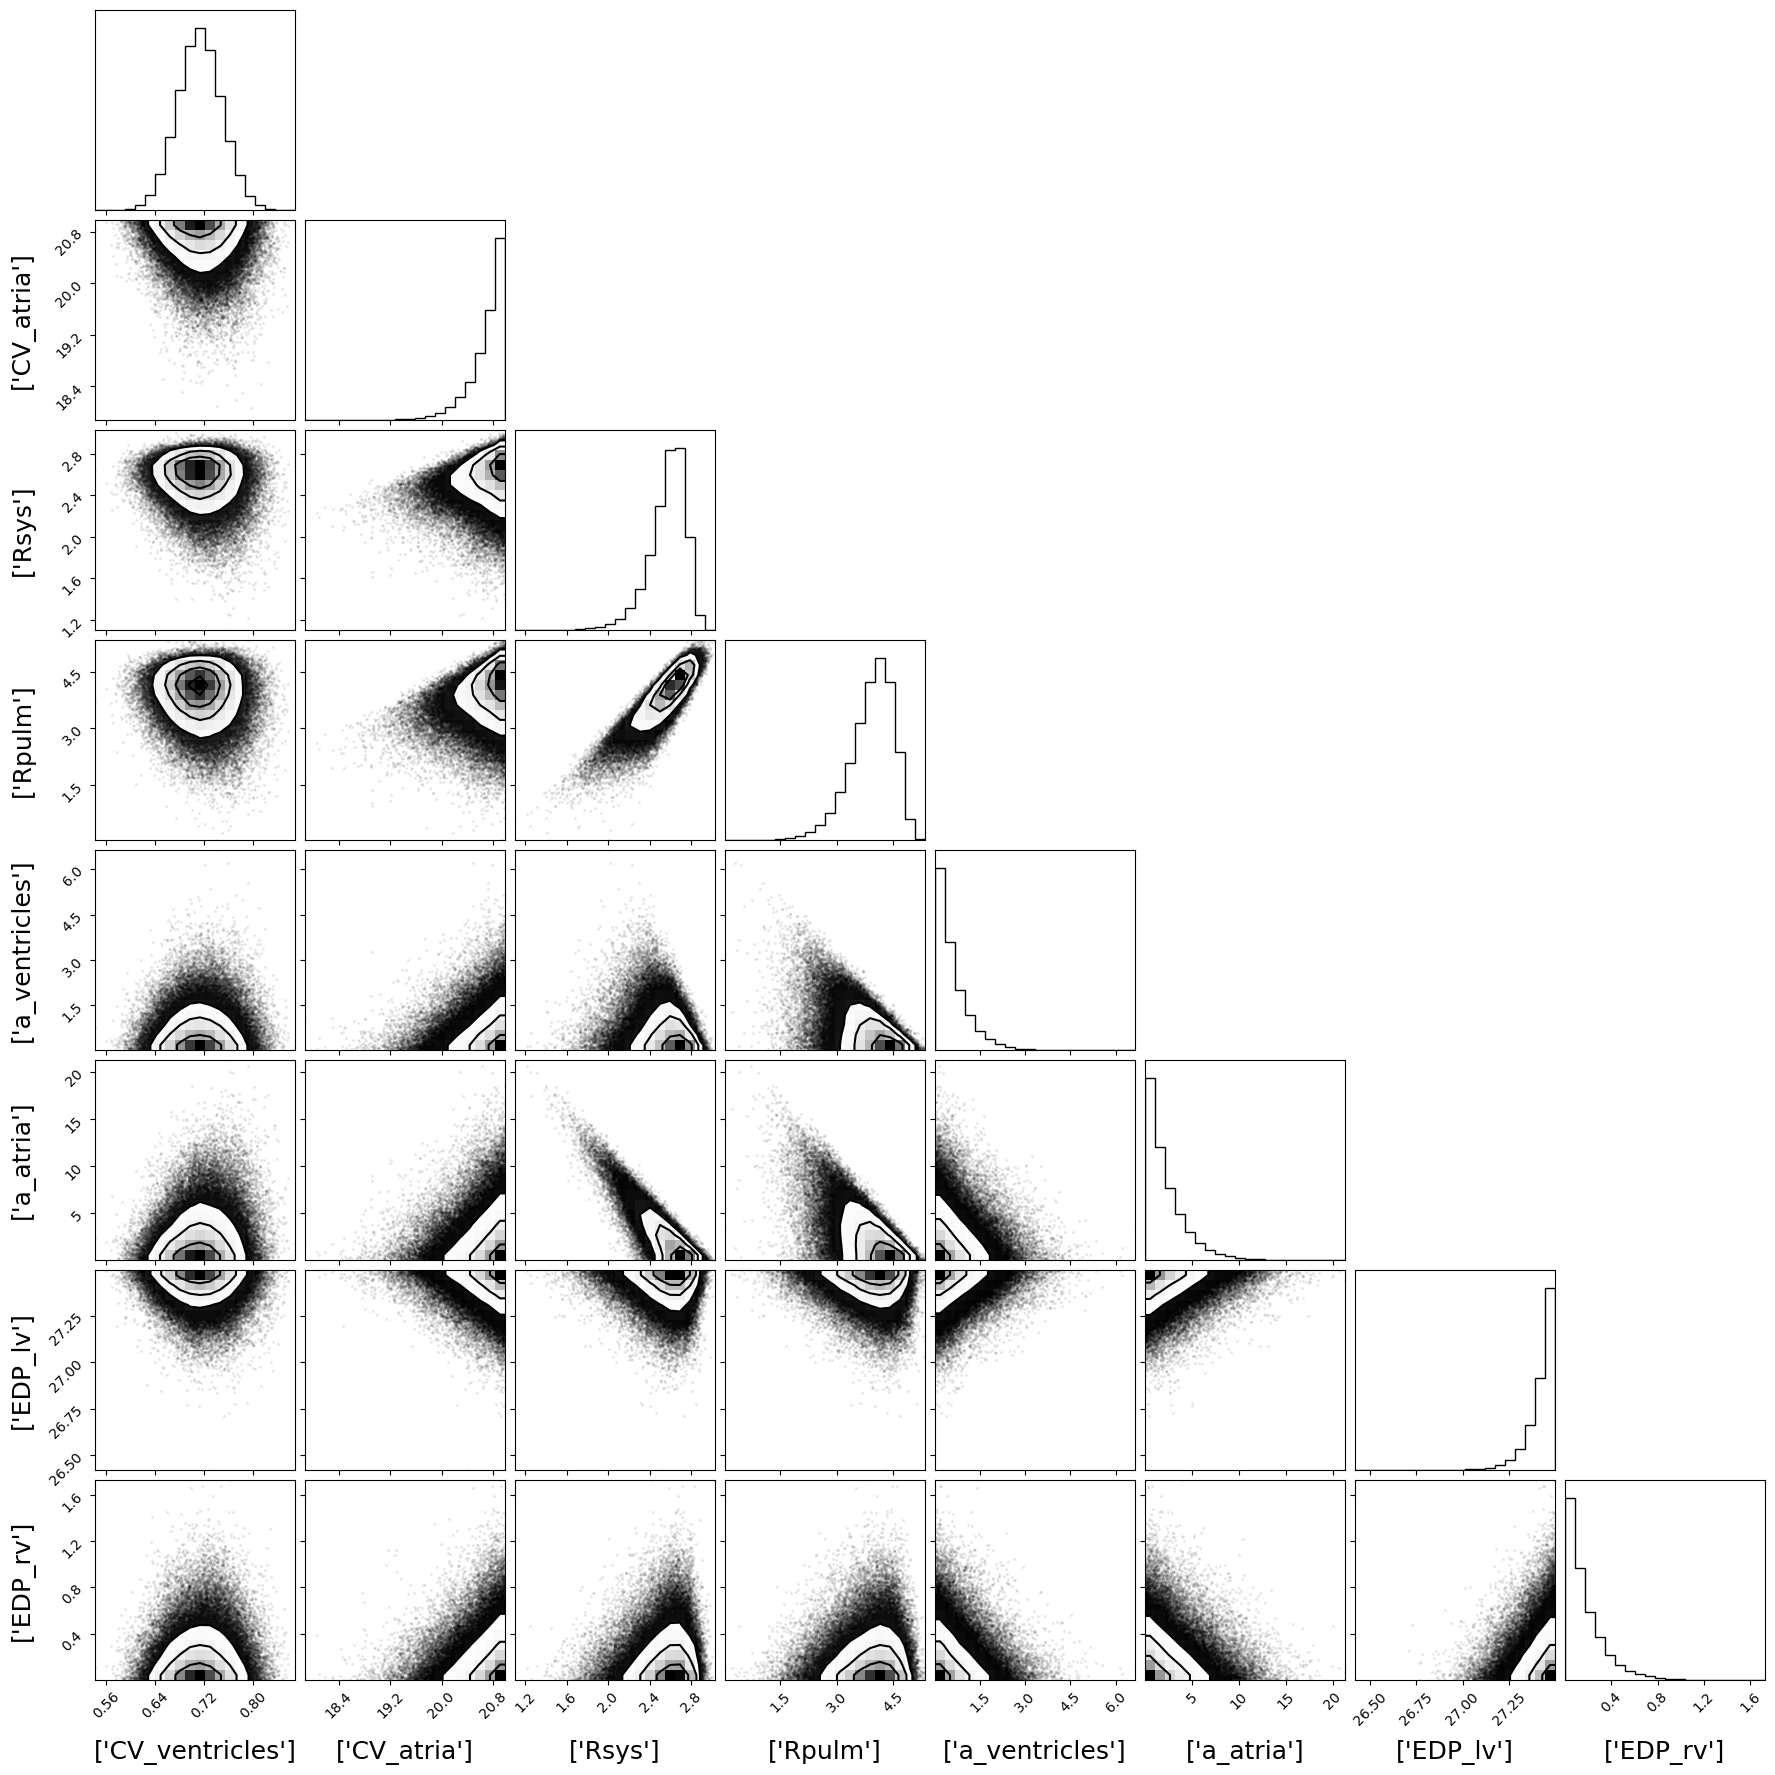

In [383]:
import corner

fig = corner.corner(
    flat_samples, labels=x_labels.values, label_kwargs=dict(fontsize=18)
);

In [393]:
samp = pd.DataFrame(flat_samples).sample(50)

In [396]:
samp.to_csv("MCMC_samples.dat", sep = " ",index=False,header=None)

In [400]:
flat_samples.mean(axis=0)

array([ 0.71271163, 20.69472615,  2.57049928,  3.93076253,  0.57806877,
        2.19736319, 27.42248993,  0.17363027])

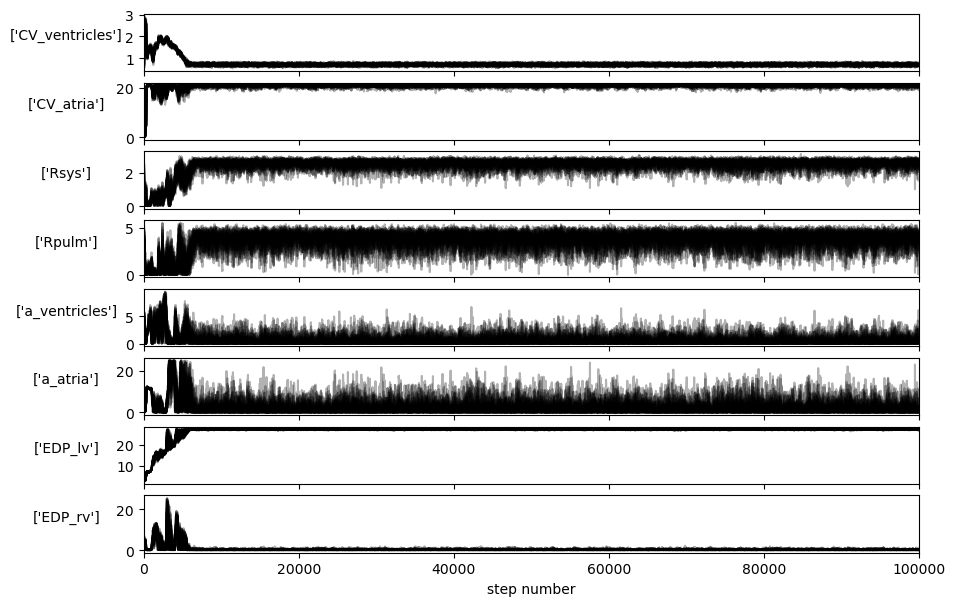

In [385]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = x_labels.values
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i],rotation=0)
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

In [401]:
x_out = pd.DataFrame(flat_samples.mean(axis=0)).T
x_out.columns = x_labels.values.squeeze()

In [402]:
emulator.predict(x_out)

tensor([[ 86.0965, 154.6154, 114.2273,   0.7963]], grad_fn=<PermuteBackward0>)